# About this Notebook

The goal of this notebook is to get a benchmark of a toxicity model on the Kaggle/Jigsaw Wikipedia comments dataset labeled for toxicity. I will use the Perspective API from Jigaw for this. 


In [89]:
import json 
import numpy as np
import pandas as pd
import os
import requests 
import time

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_rows = 999


In [90]:
from toxicity import constants, data, features, text_preprocessing, model, metrics, visualize


## Load data

In [91]:
df_train = data.load(constants.INPUT_PATH, filter=False)

## EDA

In [24]:
print(df_train.info())
df_train.head()
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB
None
               toxic   severe_toxic        obscene         threat  \
count  223549.000000  223549.000000  223549.000000  223549.000000   
mean        0.095657       0.008777       0.054306       0.003082   
std         0.294121       0.093272       0.226621       0.055431   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.00000

## Example comments

In [95]:
df_train.comment_text

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
223544    :Jerome, I see you never got around to this…! ...
223545    ==Lucky bastard== \n http://wikimediafoundatio...
223546    ==shame on you all!!!== \n\n You want to speak...
223547    MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...
223548    " \n\n == Unicorn lair discovery == \n\n Suppo...
Name: comment_text, Length: 223549, dtype: object

## Make Perspective API requests

In [41]:
api_key = os.environ.get("PERSPECTIVE_API_KEY")
url = ('https://commentanalyzer.googleapis.com/v1alpha1/comments:analyze' +    
    '?key=' + api_key)

def make_data_dict(text):  
    data_dict = {
        'comment': {'text': text},
        'languages': ['en'],
        'requestedAttributes': {'TOXICITY': {}}
    }
    return data_dict

def return_score(data_dict):    
    response = requests.post(url=url, data=json.dumps(data_dict)) 
    response_dict = json.loads(response.content) 
    try:
        score = response_dict["attributeScores"]["TOXICITY"]["summaryScore"]["value"]
    except:
        print(json.dumps(response_dict))
    return score


In [93]:
#Start fresh or from populated list
try:
    tox_scores
except:
    tox_scores = []
    

In [74]:
#Iterate through the comment text to send to the API. Add sleep to manage rate limiting.

scores_length=len(tox_scores)

print('Number of scores: ' + str(scores_length))

for i, comment in enumerate(df_train.comment_text[scores_length:]):
    if i%50==1:
        print(i)
        time.sleep(60)
    data_dict = make_data_dict(comment)
    score = return_score(data_dict)
    tox_scores.append(score)
    

627
1
51
101
151
201
251
301
351
401
451
501
551
601
651
701
751
801
851
901
951
1001
1051
1101
1151
1201
1251
1301
1351
1401
1451
1501
1551
1601
1651
1701
1751
1801
1851
1901
1951
2001
2051
2101
2151
2201
2251
2301
2351
2401
2451
2501
2551
2601
2651
2701
2751
2801
2851
2901
2951
3001
3051
3101
3151
3201
3251
3301
3351
3401
3451
3501
3551
3601
3651
3701
3751
3801
3851
3901
3951
4001
4051
4101
4151
4201
4251
4301
4351
4401
4451
4501
4551
4601
4651
4701
4751
4801
4851
4901
4951
5001
5051
5101
5151
5201
5251
5301
5351
5401
5451
5501
5551
5601
5651
5701
5751
5801
5851
5901
5951
6001
6051
6101
6151
6201
6251
6301
6351
6401
6451
6501
6551
6601
6651
6701
6751
6801
6851
6901
6951
7001
7051
7101
7151
7201
7251
7301
7351
7401
7451
7501
7551
7601
7651
7701
7751
7801
7851
7901
7951
8001
8051
8101
8151
8201
8251
8301
8351
8401
8451
8501
8551
8601
8651
8701
8751
8801
8851
8901
8951
9001
9051
9101
9151
9201
9251
9301
9351
9401
9451
9501
9551
9601
9651
9701
9751
9801
9851
9901
9951
10001
10051
10101
1

KeyboardInterrupt: 

In [96]:
#Write out scores to csv
pd.DataFrame(tox_scores).to_csv("perspective_tox_scores.csv", index=False, header=None)

#Load scores
#tox_scores = pd.read_csv("perspective_tox_scores.csv", header=None)

In [87]:
pred = np.array(tox_scores)>.5

Average precision-recall score: 0.62
[[39944  2282]
 [  256  4346]]
Accuracy Score: 0.95


(array([0.        , 0.        , 0.        , ..., 0.99526358, 0.99531095,
        1.        ]),
 array([0.00000000e+00, 2.17296827e-04, 2.10777923e-02, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([0.17194739, 0.17191645, 0.17192288, ..., 1.        , 1.        ,
        1.        ]))

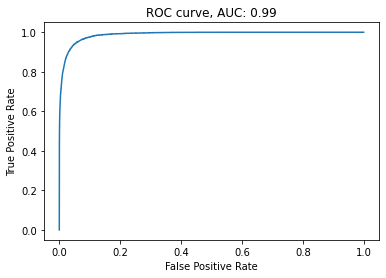

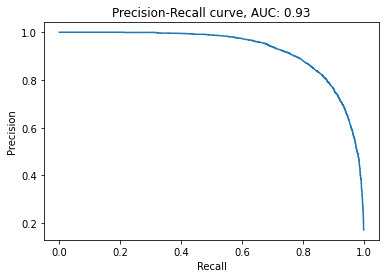

In [88]:
metrics.run_metrics(pred, tox_scores, df_train.toxic[:len(tox_scores)], visualize=True)